# Notebook for the Assignment 1

The utility functions are copied from [Stanford cs231n course](https://github.com/cs231n/cs231n.github.io). You can download the preliminary code for this assignment from [this link](http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip).

In [1]:
# this block is mostly copied from cs231n
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

To download the data I have used the script from cs213n again:

```
cd cs231n/datasets
./get_datasets.sh
```

In this next block I have used the cs231n script nearly exactly. The only change is that, on top of of making the dataset 0-mean the input dataset is also normalized to the 0-1 range.

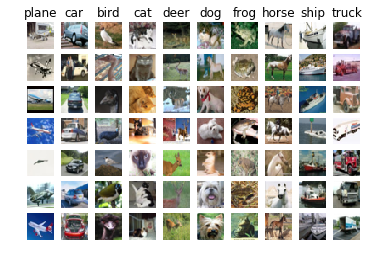

Train data shape:  (45000, 3073)
Train labels shape:  (45000,)
Validation data shape:  (5000, 3073)
Validation labels shape:  (5000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [105]:
def get_CIFAR10_data(num_training=45000, num_validation=5000, num_test=1000, num_dev=500, uniform_std=False):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Visualize some examples from the dataset.
    # We show a few examples of training images from each class.
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(classes)
    samples_per_class = 7
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # and just normalize to 0-1 range, without making the dataset 0-mean
    max_image = 255
    X_train /= max_image
    X_val /= max_image
    X_test /= max_image
    X_dev /= max_image
    
    if uniform_std:
        std_image = np.std(X_train, axis = 0)
        X_train /= std_image
        X_val /= std_image
        X_test /= std_image
        X_dev /= std_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Next block is copied from the cs231n course. My softmax (non-vectorized) implementation is in the **cs231n/classifiers/softmax.py** file.

In [106]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('calculated loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

calculated loss: 2.305317
sanity check: 2.302585


This sanity check looks ok because:

> Uniform random (with low variance) weights => predictions should be uniform => p~0.1 for each class

In this next block I have compared my implementation with the provided numerical gradient checking.

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.005247 analytic: 0.005247, relative error: 3.302147e-09
numerical: 0.001530 analytic: 0.001530, relative error: 1.567013e-08
numerical: 0.012709 analytic: 0.012709, relative error: 1.049291e-09
numerical: -0.017302 analytic: -0.017302, relative error: 4.676534e-09
numerical: 0.001391 analytic: 0.001391, relative error: 1.779925e-08
numerical: 0.020624 analytic: 0.020624, relative error: 1.305893e-09
numerical: -0.001041 analytic: -0.001041, relative error: 1.764105e-08
numerical: -0.004435 analytic: -0.004435, relative error: 7.491180e-09
numerical: 0.002567 analytic: 0.002567, relative error: 9.819127e-09
numerical: -0.000327 analytic: -0.000327, relative error: 1.093610e-07
numerical: 0.104515 analytic: 0.104515, relative error: 1.017347e-09
numerical: -0.042494 analytic: -0.042494, relative error: 1.059413e-09
numerical: 0.238733 analytic: 0.238733, relative error: 9.154253e-11
numerical: -0.040294 analytic: -0.040294, relative error: 3.637553e-10
numerical: 0.053325 an

And now I compare my non-vectorized implementation with the vectorized one. My implementation is again in the **cs231n/classifiers/softmax.py** file.

In [107]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.305318e+00 computed in 0.131653s
vectorized loss: 2.305318e+00 computed in 0.009721s
Loss difference: 0.000000
Gradient difference: 0.000000


In [108]:
from cs231n.classifiers import Softmax

In [112]:
np.random.seed(1)
softmax = Softmax()
lr= 0.1
reg=0.0
# 0.0 corresponds to no momentum
momentum = 0.0
# 1.0 corresponds to no decay
decay = 1.0
# either xavier or standard
init = 'standard'
losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                             X_val, y_val,
                                                             learning_rate=lr, 
                                                             reg=reg, 
                                                             num_iters=18000,
                                                             momentum=momentum,
                                                             decay=decay,
                                                             initialization=init)

In [113]:
import matplotlib.gridspec as gridspec
def plotNicely(xlabel='epochs'):
    gs1 = gridspec.GridSpec(1, 1)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(gs1[0, 0])
    ax.plot(total_train_losses[:], c='b')
    ax.plot(total_val_losses[:], c='r')
    ax.legend(['Training loss','Validation loss'])
    ax.text(0.7, 0.8, 'Learning rate: %e \nRegularization: %e \nMomentum: %e \nDecay ratio: %e \nInitialization: %s' %(lr, reg, momentum, decay, init),
             style='italic', bbox={'facecolor':'red', 'alpha':0.5}, transform = ax.transAxes);
    ax.set_title('Training vs. Validation Loss');
    ax.set_xlabel(xlabel)
    ax.set_ylabel('loss')
    


    # Visualize the learned weights for each class
    w = softmax.W[:-1,:] # strip out the bias
    w = w.reshape(32, 32, 3, 10)

    w_min, w_max = np.min(w), np.max(w)

    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    gs2 = gridspec.GridSpec(2, 5)
    gs2.update(left=1, right=2, hspace=0.05)
    for rows in range(2):
        for cols in range(5):
            i = rows*5+cols
            ax = fig.add_subplot(gs2[rows, cols])
            wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
            ax.imshow(wimg.astype('uint8'))
            ax.axis('off')
            ax.set_title(classes[i])

    y_test_pred = softmax.predict(X_test)
    test_accuracy = np.mean(y_test == y_test_pred)
    print('Final test set accuracy: %f' % (test_accuracy, ))

Final test set accuracy: 0.383000


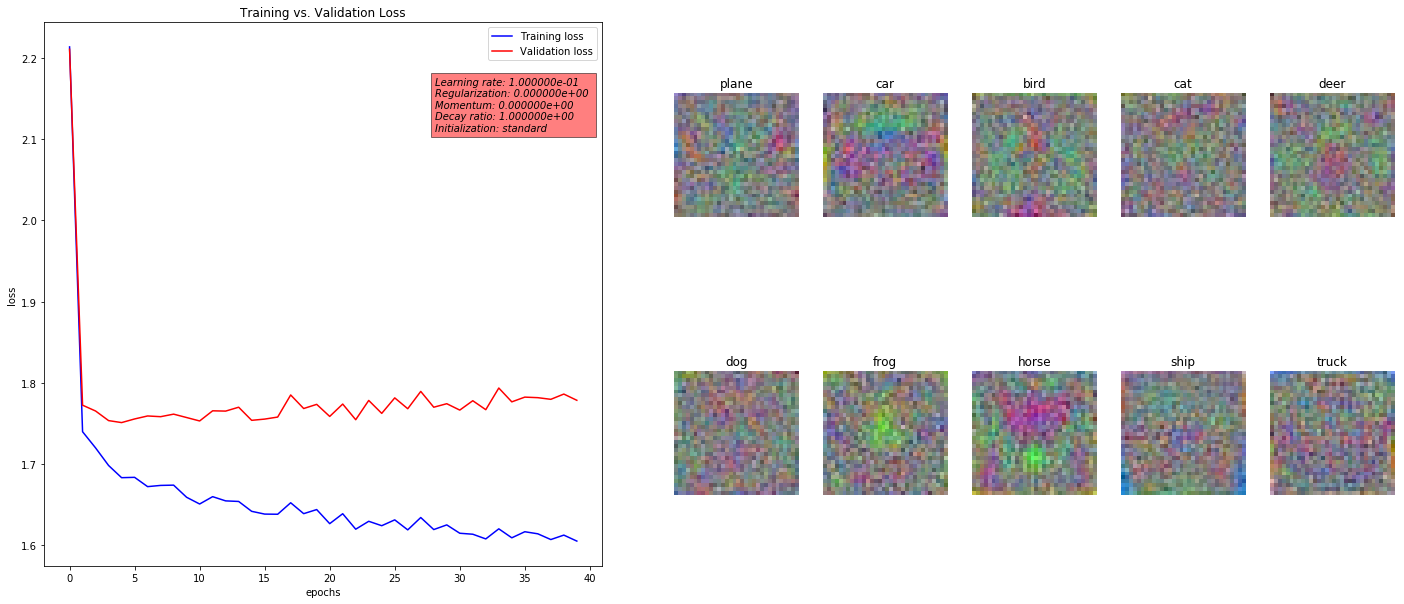

In [114]:
plotNicely()

Final test set accuracy: 0.399000


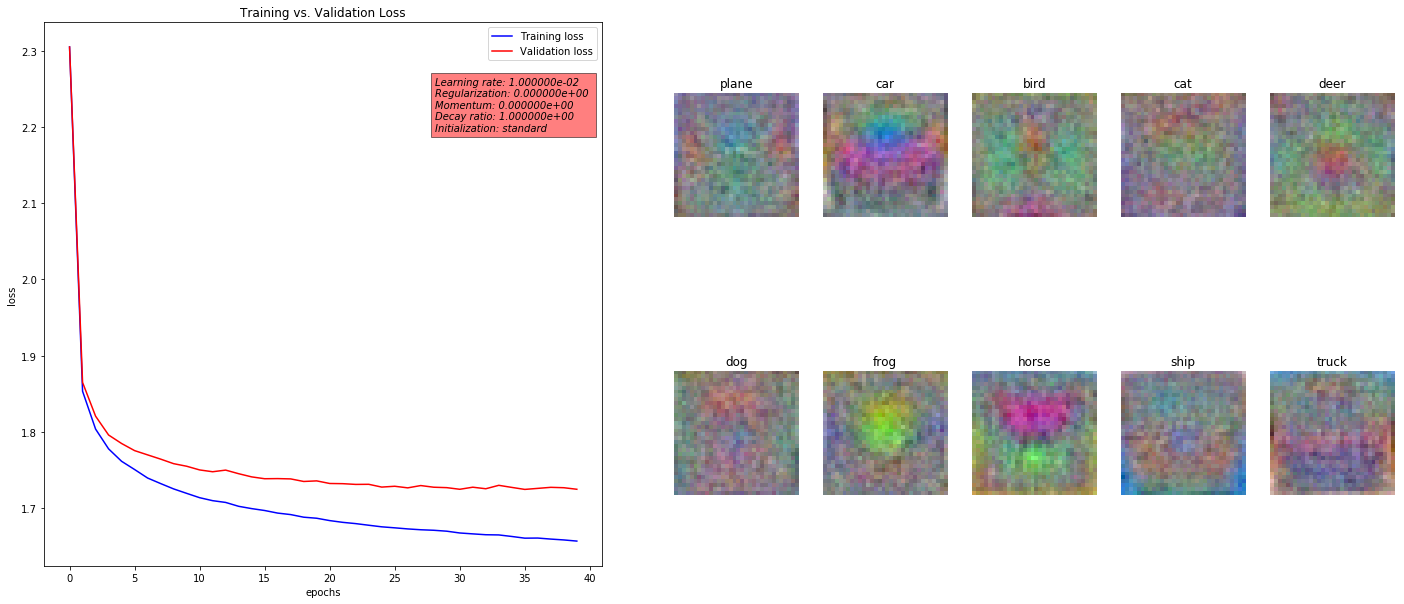

In [10]:
np.random.seed(1)
softmax = Softmax()
lr= 0.01
reg=0.0
momentum = 0.0
decay = 1.0
init = 'standard'
losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                             X_val, y_val,
                                                             learning_rate=lr, 
                                                             reg=reg, 
                                                             num_iters=18000,
                                                             momentum=momentum,
                                                             decay=decay,
                                                             initialization=init)
plotNicely()

Final test set accuracy: 0.366000


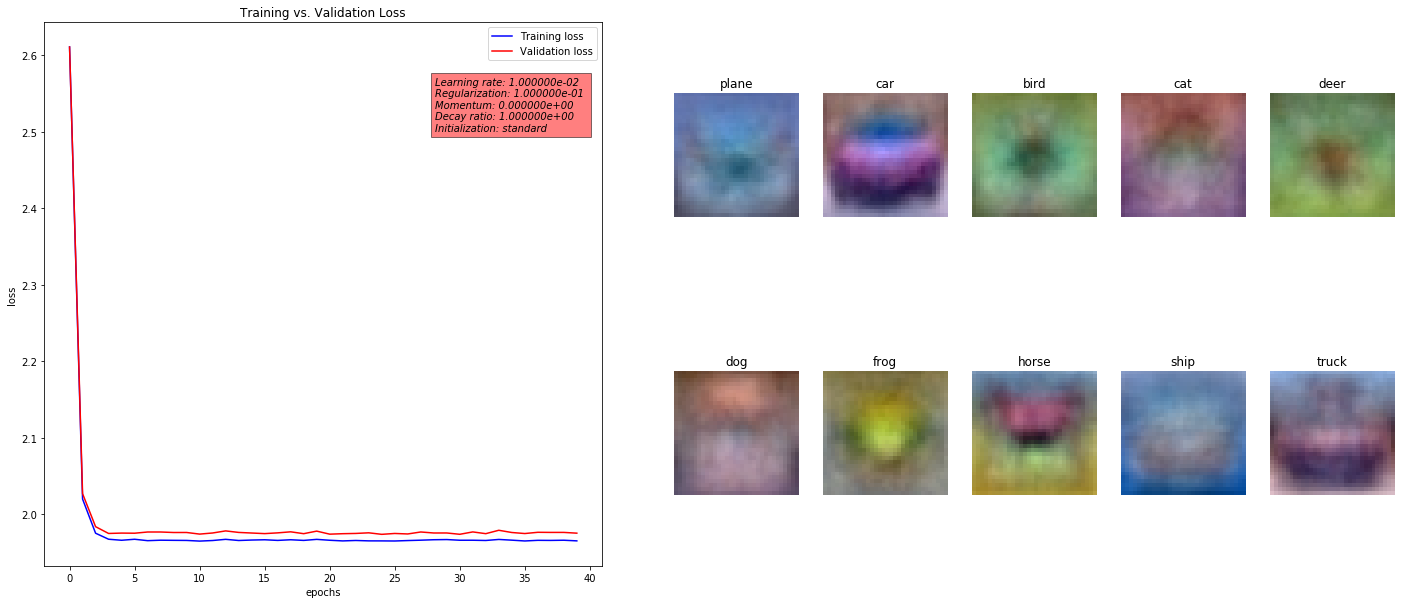

In [11]:
np.random.seed(1)
softmax = Softmax()
lr= 0.01
reg=0.1
momentum = 0.0
decay = 1.0
init = 'standard'
losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                             X_val, y_val,
                                                             learning_rate=lr, 
                                                             reg=reg, 
                                                             num_iters=18000,
                                                             momentum=momentum,
                                                             decay=decay,
                                                             initialization=init)

plotNicely()

Final test set accuracy: 0.314000


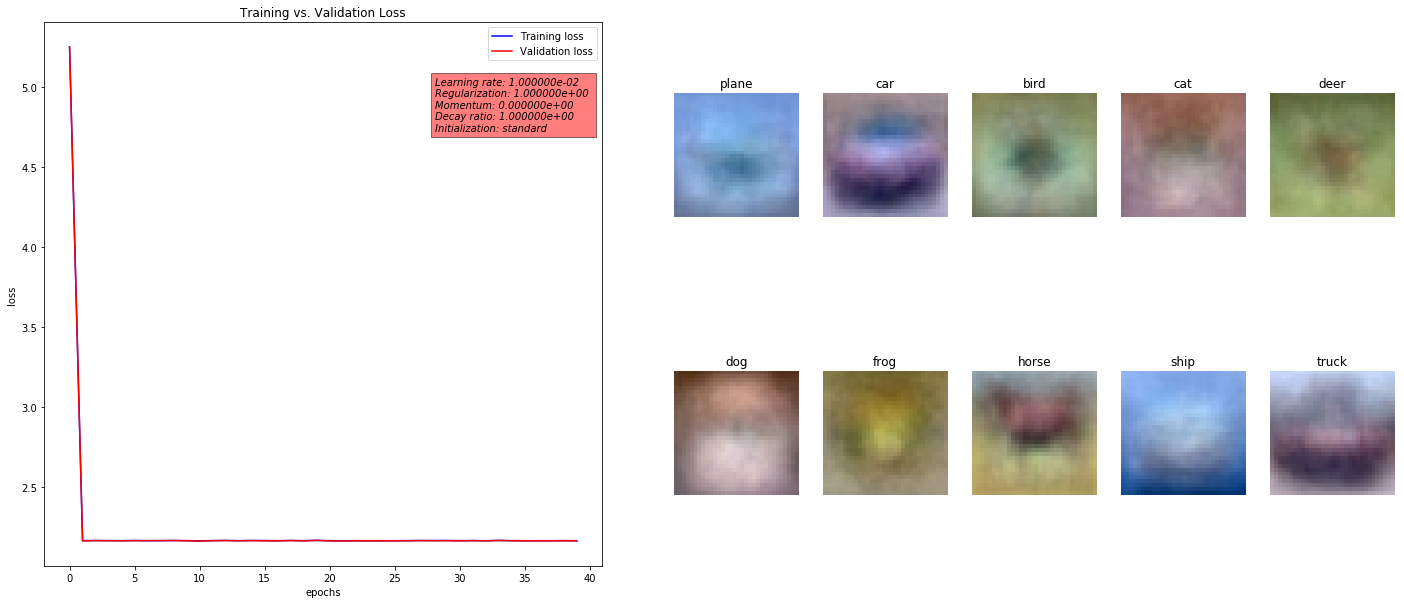

In [12]:
np.random.seed(1)
softmax = Softmax()
lr= 0.01
reg= 1.0
momentum = 0.0
decay = 1.0
init = 'standard'
losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                             X_val, y_val,
                                                             learning_rate=lr, 
                                                             reg=reg, 
                                                             num_iters=18000,
                                                             momentum=momentum,
                                                             decay=decay,
                                                             initialization=init)

plotNicely()

# Comments about the results
- With a high learning rate, the loss curve becomes *choppy*, maybe the gradient descent is jumping over the ravines.
- Without regularization we might want to use early stopping to avoid overfitting - but then your loss may not be as low so it is better to find a good regularization value.
- Overregularization ends up with an overall worse model. The training and validation loss curves becomes nearly identical, so our model is probably underfitting.
- *Smoother* weight matrices does not seem to relate to better performance. The *smoothest* ones were achieved by the highest regularization case yet those models are not the best performing ones.

# Improvements

Here I have implemented grid search for the hyperparameters. The training also incorporates
- Images have std=1 as well as being zero-mean,
- Xavier initialization, 
- Increased training set size,
- Learning rate decay of 0.9 at each epoch and,
- Nesterov momentum (at 0.9).

After the hyperparameter selection create a bunch of classifiers using different initial weights and then take the average of the results by voting.

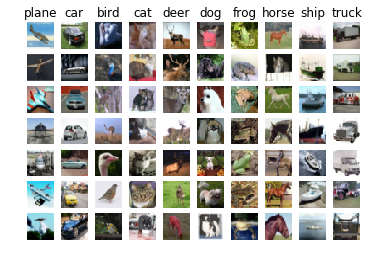

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [13]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data(num_training=49000, num_validation=1000, uniform_std=True)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

In [ ]:
np.random.seed(1)
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

#starting and ending values of the hyperparameters to search (in logspace)
start_reg = 1
end_reg = -7
start_lr = -4
end_lr = -7
#number of hyperparameters to check
nr_of_hyper = 9

learning_rates = np.logspace(start_lr, end_lr, num=nr_of_hyper )
regularization_strengths = np.logspace(start_reg, end_reg, num=nr_of_hyper)
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [2.5e4, 5e4]


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

zs = []
best_lr = best_reg = []
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                                     X_val, y_val,
                                                                     learning_rate=lr, 
                                                                     reg=reg, 
                                                                     num_iters=4500,
                                                                     decay = 0.9,
                                                                     momentum=0.999,
                                                                     initialization='xavier')
        
        y_train_pred = softmax.predict(X_train)
        training_acc = np.mean(y_train == y_train_pred)
        print('training accuracy for reg %e and lr %e: %f' % (reg, lr, training_acc))
        
        y_val_pred = softmax.predict(X_val)
        validation_acc = np.mean(y_val == y_val_pred)
        print('validation accuracy for reg %e and lr %e: %f' % (reg, lr, validation_acc))
        print('---------------------------------------------------------')
        zs.append(validation_acc)
        results[(lr,reg)] = (training_acc,validation_acc)
        if validation_acc > best_val:
            best_val = validation_acc
            best_softmax = softmax
            best_lr = lr
            best_reg = reg
            best_losses = losses
            best_total_val_losses = total_train_losses
            best_total_train_losses = total_train_losses

#pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
#for lr, reg in sorted(results):
#    train_accuracy, val_accuracy = results[(lr, reg)]
#    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('with reg %e and lr %e' %(best_reg, best_lr))

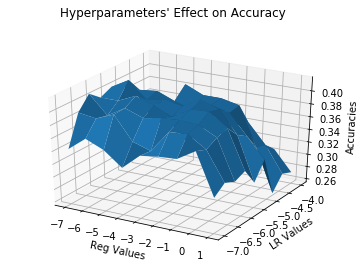

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
reg_vals = np.linspace(start_reg, end_reg, nr_of_hyper)
lr_vals = np.linspace(start_lr, end_lr, nr_of_hyper)
REGVALS, LRVALS = np.meshgrid(reg_vals, lr_vals)
VALIDATION_ACC = np.asarray(zs).reshape(REGVALS.shape)
ax.plot_surface(REGVALS, LRVALS, VALIDATION_ACC)

ax.set_xlabel('Reg Values')
ax.set_ylabel('LR Values')
ax.set_zlabel('Accuracies')
fig.suptitle('Hyperparameters\' Effect on Accuracy');

In [18]:
np.random.seed(1)
softmax = Softmax()
lr= best_lr
reg= best_reg
momentum = 0.999
decay = 0.9
init = 'xavier'
losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                             X_val, y_val,
                                                             learning_rate=lr, 
                                                             reg=reg, 
                                                             num_iters=18000,
                                                             decay=decay,
                                                             momentum=momentum,
                                                             initialization=init)

Final test set accuracy: 0.400000


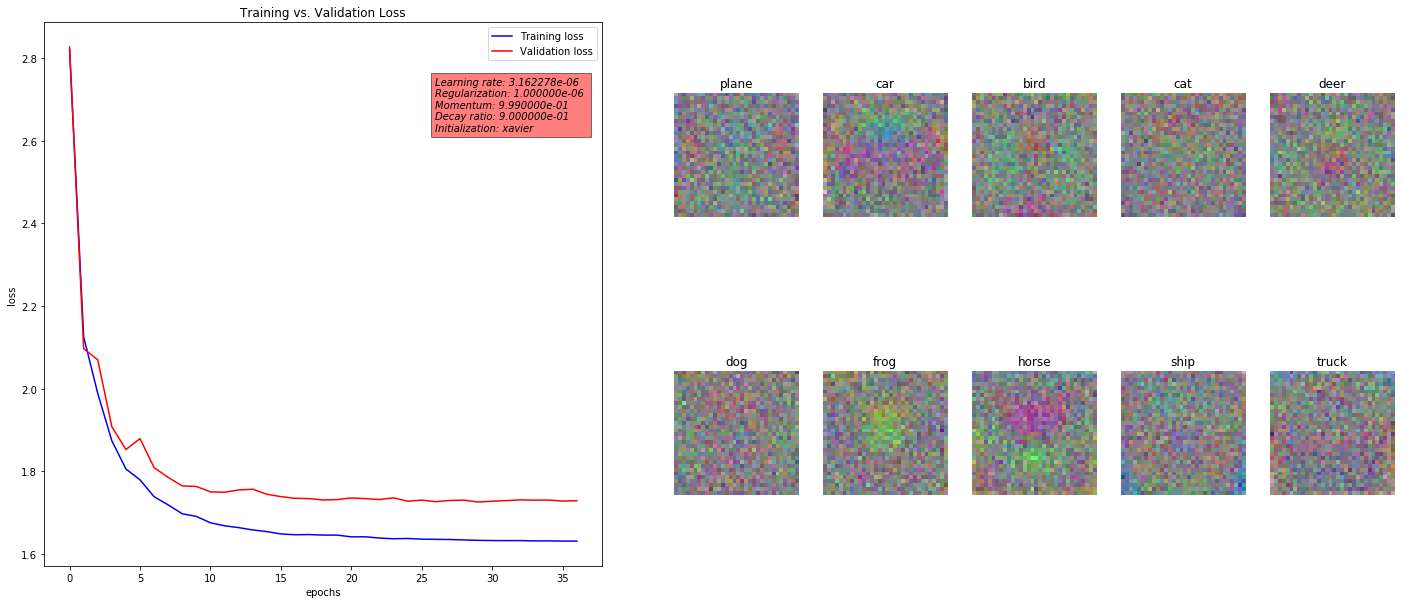

In [19]:
plotNicely()

Create some classifiers and vote on the predictions to create an ensemble. Note that I have increased the regularization parameter a little since it looks like the above model is close to overfitting.

In [31]:
classifiers = []

In [45]:
for i in range(25):
    np.random.seed(i)
    softmax = Softmax()
    lr= best_lr
    reg= best_reg
    momentum = 0.999
    decay = 0.9
    init = 'xavier'
    losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                                 X_val, y_val,
                                                                 learning_rate=lr, 
                                                                 reg=reg, 
                                                                 num_iters=18000,
                                                                 decay=decay,
                                                                 momentum=momentum,
                                                                 initialization=init)
    classifiers.append(softmax)                   

In [101]:
y_test_predictions = []
for classifier in classifiers:
    y_test_pred = classifier.predict(X_test)
    y_test_predictions.append(y_test_pred)
    test_accuracy = np.mean(y_test == y_test_pred)
y_test_predictions = np.asarray(y_test_predictions)
pred = np.zeros(1000)
for i in range(1000):
    pred[i] = np.argmax(np.bincount(y_test_predictions[:,i], minlength=10))
test_accuracy = np.mean(y_test == pred)
print('Ensemble test accuracy is %f' %test_accuracy)

Ensemble test accuracy is 0.402000


# Comments about the improvements
- I did not directly guess the grid-search limits. I started with a wider search span initially, plotted the resultant accuracies as shown in the **Hyperparameters' Effect on Accuracy** figure above and then started a new grid-search with narrower limits on learning rate and regularization.
- Momentum helped with the training speed a lot, but in the end I reduced the learning rate so much that the loss plots became similar to the 0 momentum case.
- Decay helped with the *choppiness* of the loss curves.
- Xavier initialization did not create much difference. Probably because this is a single layer network.
- Ensembling also did not yield any benefit, rather it proved that training was more or less robust to the weight initialization.
- Increasing training set size was not significant since I had already used 45000 initially. -
- Making the images' std equal to 1 and mean equal to 0 made a marginal difference but it is simple and fast.